# Street View House Numbers classification using CNN
## SEEPJA PAYASI

---


# Description
+ The Street View House Numbers (SVHN) is a real-world image dataset used for developing machine learning and object recognition algorithms. It is one of the commonly used benchmark datasets as It requires minimal data preprocessing and formatting. It also comes from a significantly harder real world problem of recognising digits and numbers in natural scene images. The images lack any contrast normalisation, contain overlapping digits and distracting features which makes it a much more difficult problem.
+ It has been used in neural networks created by Google to read house numbers and match them to their geolocations. This is a great benchmark dataset to play with, learn and train models that accurately identify street numbers, and incorporate into all sorts of projects.
+ Full train set + half extra set for training (Could not use full extra set due to RAM limit).
+ Grayscaling + normalizing images.
+ Keras's image data generator used for more training images.
+ Typical CNN architecture.
+ The SVHN dataset originates from http://ufldl.stanford.edu/housenumbers/.

## **1. Imports**

**Importing modules**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import tensorflow
from tensorflow import keras
from scipy.io import loadmat
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

## **2. Load data**

**Function to load data**

In [2]:
def load_data(path):
    data = loadmat(path)
    return data['X'], data['y']

In [3]:
X_train, y_train = load_data('/Users/seepja/Downloads/archive/train_32x32.mat')
X_test, y_test = load_data('/Users/seepja/Downloads/archive/test_32x32.mat')
X_extra, y_extra = load_data('/Users/seepja/Downloads/archive/extra_32x32.mat')

**Data shapes after loaded**

In [4]:
print("Training set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)
print("Extra training set:", X_extra.shape, y_extra.shape)

Training set: (32, 32, 3, 73257) (73257, 1)
Test set: (32, 32, 3, 26032) (26032, 1)
Extra training set: (32, 32, 3, 531131) (531131, 1)


## **3. Preprocessing**

**Transpose the image arrays**

In [5]:
X_train, y_train = X_train.transpose((3,0,1,2)), y_train[:,0]
X_test, y_test = X_test.transpose((3,0,1,2)), y_test[:,0]
X_extra, y_extra = X_extra.transpose((3,0,1,2)), y_extra[:,0]

**Add 300000 samples from the extra set to training set**

In [6]:
X_train = np.concatenate((X_train, X_extra[:300000]))
y_train = np.concatenate((y_train, y_extra[:300000]))

**Free some RAM usage**

In [7]:
del X_extra, y_extra

**Data shapes after transposing and merging**

In [8]:
print("Training set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)

Training set: (373257, 32, 32, 3) (373257,)
Test set: (26032, 32, 32, 3) (26032,)


**Function to plot sample images**

In [9]:
def plot_images(images, labels, num_row=2, num_col=5):

    plt.rcParams['axes.grid'] = False
    fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_col,2*num_row))
    for i in range(num_row * num_col):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(images[i], cmap="gray")
        ax.set_title(labels[i],weight='bold',fontsize=20)
    plt.tight_layout()
    
    plt.show()

**Show sample train images**

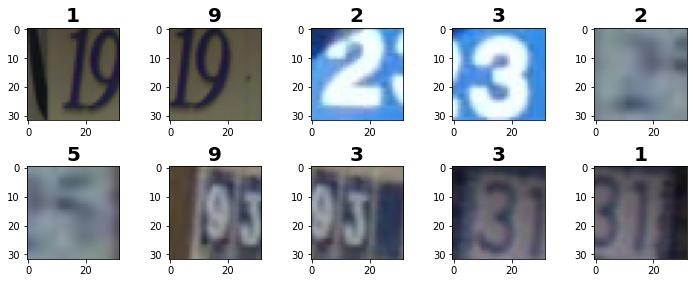

In [10]:
plot_images(X_train, y_train)

**Show sample test images**

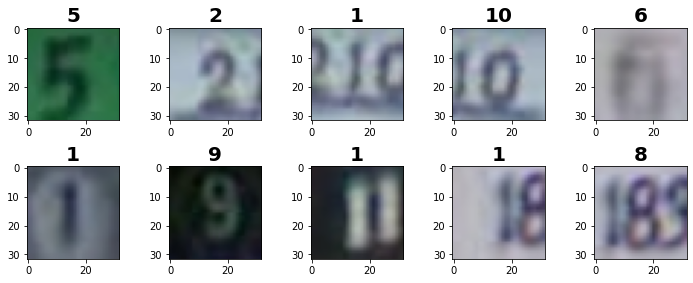

In [11]:
plot_images(X_test, y_test)

**Converting label '10' -> '0'**

In [12]:
y_train[y_train == 10] = 0
y_test[y_test == 10] = 0

**Function to plot distribution of data**

In [13]:
def plot_distribution(y1, y2, title1, title2):

    plt.rcParams['axes.facecolor'] = '#E6E6E6'
    plt.rcParams['axes.grid'] = True
    plt.rcParams['axes.axisbelow'] = True
    plt.rcParams['grid.color'] = 'w'
    plt.rcParams['figure.figsize'] = (12, 4)

    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
    fig.suptitle('Class Distribution', fontsize=15, fontweight='bold', y=1.05)

    ax1.bar(np.arange(10),np.bincount(y1))
    ax1.set_title(title1)
    ax1.set_xlim(-0.5, 9.5)
    ax1.set_xticks(np.arange(10))
    ax2.bar(np.arange(10),np.bincount(y2),color='coral')
    ax2.set_title(title2)

    fig.tight_layout()

**Plotting class distribution of training set and test set**

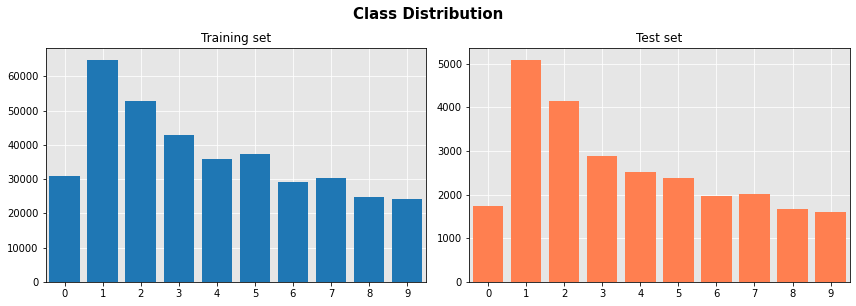

In [14]:
plot_distribution(y_train, y_test, "Training set", "Test set")

**Splitting train set into train and validation set**

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

**Converting label '10' -> '0'**

In [16]:
y_val[y_val == 10] = 0

**Plotting class distribution of training set and validation set**

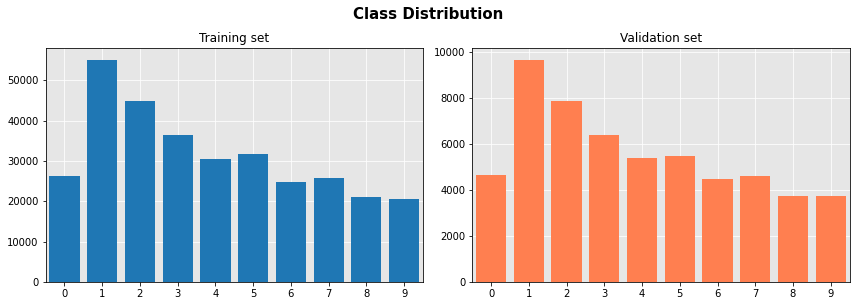

In [17]:
plot_distribution(y_train, y_val, "Training set", "Validation set")

**Turn all images into grayscale**

In [18]:
X_train = rgb2gray(X_train)
X_test = rgb2gray(X_test)
X_val = rgb2gray(X_val)

**Plotting train images after grayscaling**

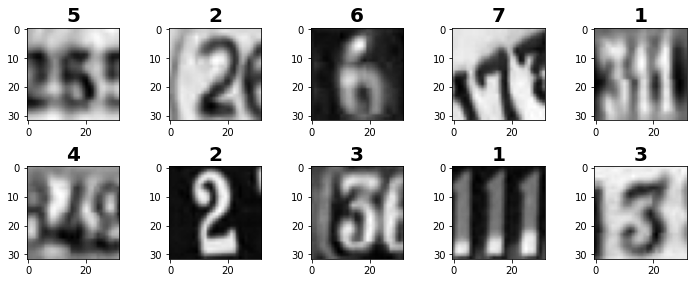

In [19]:
plot_images(X_train, y_train)

**Calculate the mean and the std on the training dataset**

In [20]:
train_mean = np.mean(X_train, axis=0)
train_std = np.std(X_train, axis=0)

**Normalize images** 

+ Normalization refers to normalizing the data dimensions so that they are of approximately the same scale. Divide each dimension by its standard deviation, once it has been zero-centered.

In [21]:
X_train = (X_train - train_mean) / train_std
X_test = (X_test - train_mean)  / train_std
X_val = (X_val - train_mean) / train_std

**Replot training images to see the difference**

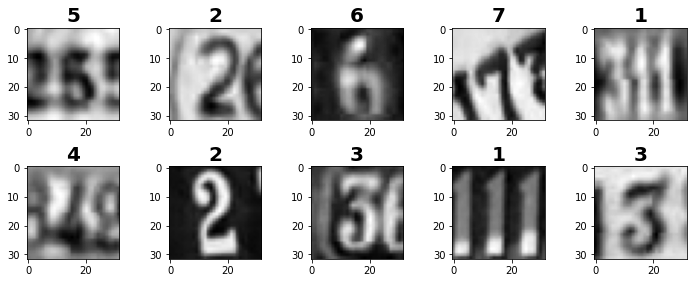

In [22]:
plot_images(X_train, y_train)

**Fit the OneHotEncoder**

In [23]:
enc = OneHotEncoder().fit(y_train.reshape(-1, 1))

**Transform the label values to a one-hot-encoding scheme (ready for CNN)**

In [24]:
y_train = enc.transform(y_train.reshape(-1, 1)).toarray()
y_test = enc.transform(y_test.reshape(-1, 1)).toarray()
y_val = enc.transform(y_val.reshape(-1, 1)).toarray()

**Y shapes after OneHotEncoding**

In [25]:
print("Training set", y_train.shape)
print("Validation set", y_val.shape)
print("Test set", y_test.shape)

Training set (317268, 10)
Validation set (55989, 10)
Test set (26032, 10)


**Reshape X from 3 dimensions to 4 dimensions (ready for CNN)**

In [26]:
X_train = X_train.reshape(-1,32,32,1)
X_test = X_test.reshape(-1,32,32,1)
X_val = X_val.reshape(-1,32,32,1)

## **4. Building and training model**

**Define data augmentation**
+ In order to get more robust results out of our model, we are going to augment the images in the dataset, by randomly rotating them, zooming them in and out, shifting them up and down (IMPORTANT NOTE: It is best that we do not shift them horizontally, since there are also distracting digits in the images), shifting their channels and shearing them.

In [27]:
datagen = ImageDataGenerator(rotation_range=8,
                             zoom_range=[0.95, 1.05],
                             height_shift_range=0.10,
                             shear_range=0.15)

**Define CNN model**

In [28]:
keras.backend.clear_session()

model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), padding='same', 
                           activation='relu',
                           input_shape=(32, 32, 1)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, (3, 3), padding='same', 
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    

    keras.layers.Conv2D(64, (3, 3), padding='same', 
                           activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3, 3), padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    

    keras.layers.Conv2D(128, (3, 3), padding='same', 
                           activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (3, 3), padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.4),    
    keras.layers.Dense(10,  activation='softmax')
])

early_stopping = tensorflow.keras.callbacks.EarlyStopping(patience=8)
optimizer = tensorflow.keras.optimizers.Adam(amsgrad=True)
model_checkpoint = tensorflow.keras.callbacks.ModelCheckpoint('best_cnn.h5', 
                   save_best_only=True)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

**Print out model's summary**

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 64)        2

**Fitting model**
+ Fit model in order to determine best learning rate

In [30]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=256),
                              epochs=10, validation_data=(X_val, y_val),
                              callbacks=[early_stopping, model_checkpoint])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
1240/1240 [==============================] - 563s 454ms/step - loss: 1.3453 - accuracy: 0.4954 - val_loss: 0.2049 - val_accuracy: 0.9436
Epoch 2/10
1240/1240 [==============================] - 626s 505ms/step - loss: 0.2471 - accuracy: 0.9322 - val_loss: 0.1223 - val_accuracy: 0.9684
Epoch 3/10
1240/1240 [==============================] - 592s 478ms/step - loss: 0.1756 - accuracy: 0.9529 - val_loss: 0.1059 - val_accuracy: 0.9736
Epoch 4/10
1240/1240 [==============================] - 581s 469ms/step - loss: 0.1525 - accuracy: 0.9596 - val_loss: 0.0969 - val_accuracy: 0.9759
Epoch 5/10
1240/1240 [==============================] - 615s 496ms/step - loss: 0.1366 - accuracy: 0.9633 - val_loss: 0.0953 - val_accuracy: 0.9775
Epoch 6/10
1240/1240 [==============================] - 635s 512ms/step - loss: 0.1292 - accuracy: 0.9660 - val_loss: 0.0900 - val_accuracy: 0.9777
Epoch 7/10
1240/1240 [==============

## **5. Visualizations and insights**

**Evaluate train and validation accuracies and losses**

In [31]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

**Visualize epochs vs. train and validation accuracies and losses**

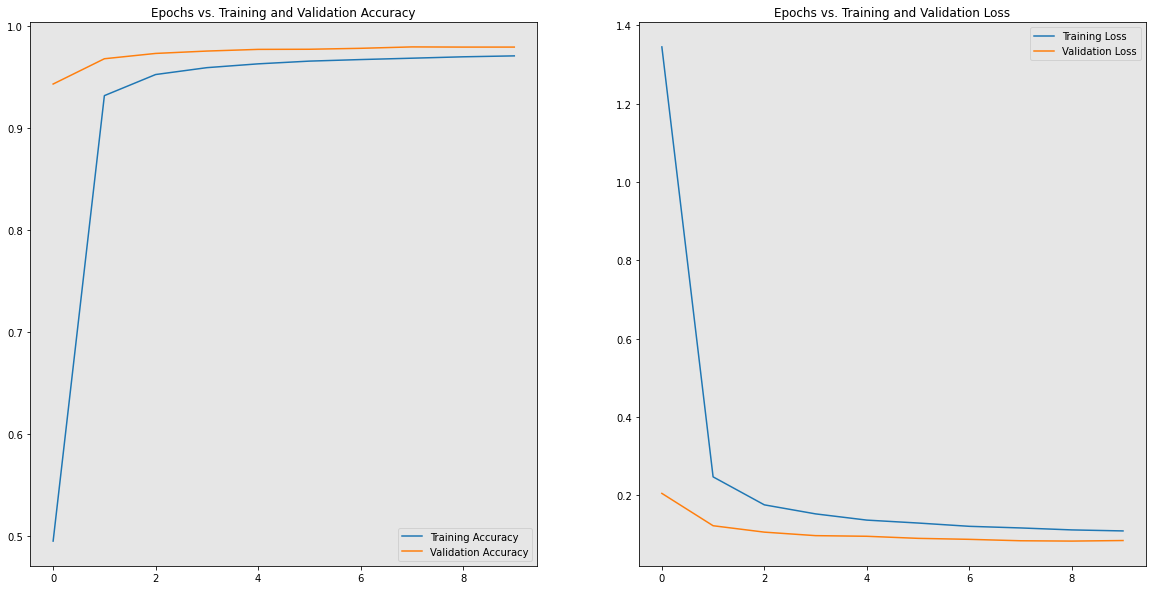

In [32]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Epochs vs. Training and Validation Accuracy')
    
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Epochs vs. Training and Validation Loss')

plt.show()

+ After seeing how the algorithm converged, we can now evaluate the model's performance on the test data.

**Evaluate model on test set**

In [33]:
test_loss, test_acc = model.evaluate(x=X_test, y=y_test, verbose=0)

print('Test accuracy is: {:0.4f} \nTest loss is: {:0.4f}'.
      format(test_acc, test_loss))

Test accuracy is: 0.9691 
Test loss is: 0.1380


+ This result implies that the error ranges from ~3% to ~3.09%

**Get predictions and apply inverse transformation to the labels**

In [34]:
y_pred = model.predict(X_train)

y_pred = enc.inverse_transform(y_pred)
y_train = enc.inverse_transform(y_train)

**Plot the confusion matrix for training set**
+ The Confusion Matrix of the model on the training data, so as to get a sense of how it performs on each class label and how the misclassifications are distributed.

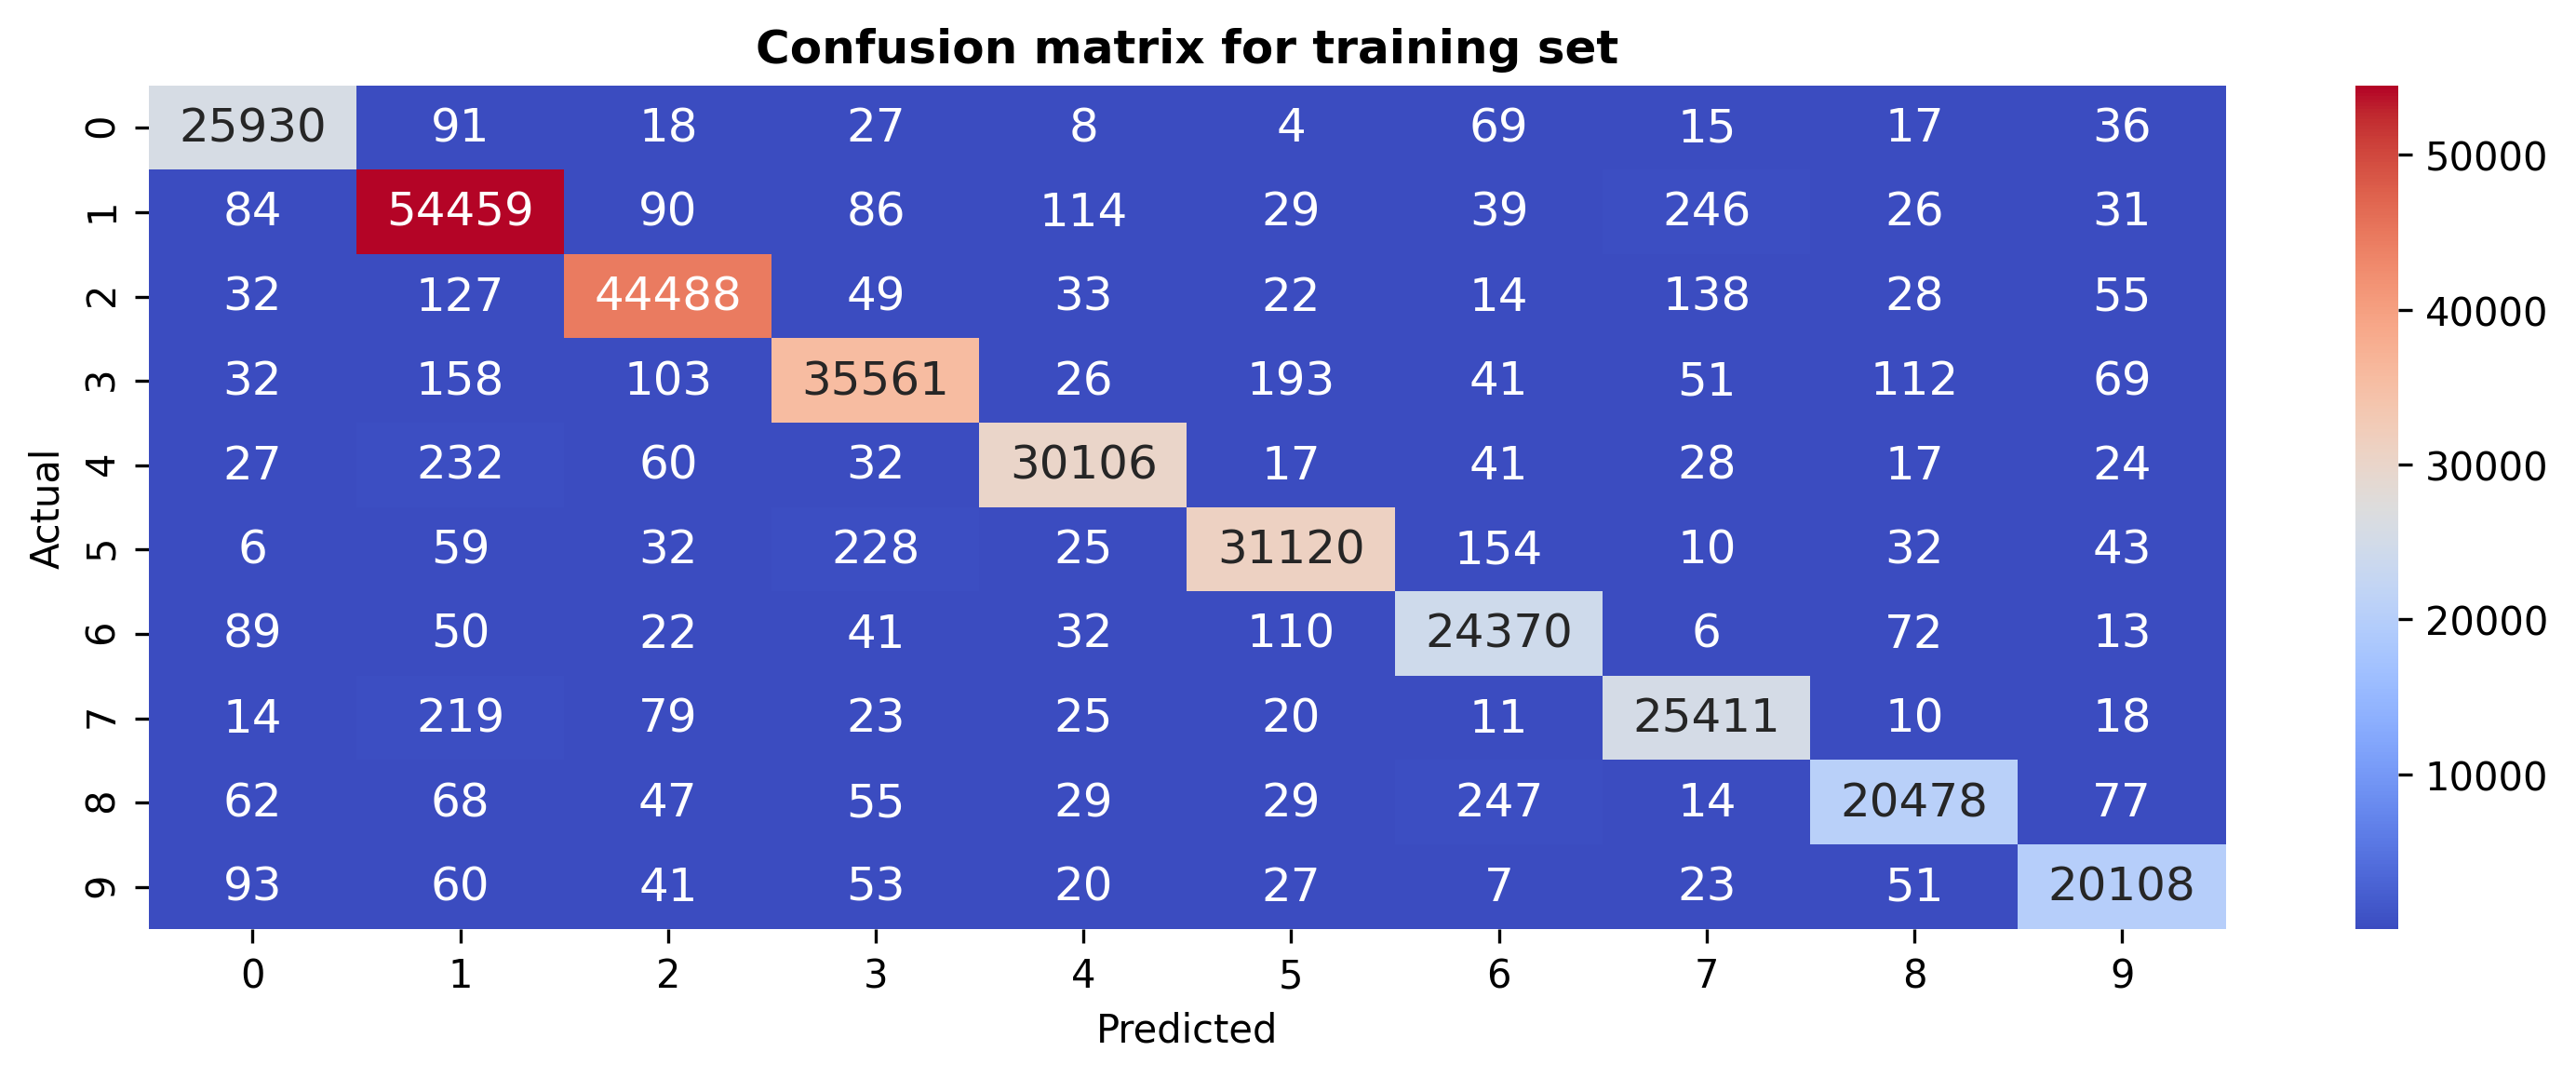

In [35]:
plt.figure(dpi=300)
cm = confusion_matrix(y_train, y_pred)
plt.title('Confusion matrix for training set', weight='bold')
sns.heatmap(cm,annot=True,fmt='g',cmap='coolwarm',annot_kws={"size": 12})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## **6. Conclusion**
+ In this project, I have trained a Convolutional Neural Network (CNN) to recognize the digits in the Street View House Numbers dataset(SVHN). It should be noted that there is quite a bit of room for tuning and different architectures so as to improve the accuracy of the model; nonetheless, the  results obtained here are pretty good given the simplicity of this approach.